# Lab: PCA Analysis and Super-Resolution on EO Images

In this lab, we will:
1. Perform PCA analysis on land-cover patches from EO images
2. Apply autoencoder for super-resolution enhancement

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from tensorflow.keras import layers, models
from PIL import Image
from skimage.transform import resize

## Task 1: PCA on EO patches (land-cover)

I will extract patches from different land-cover types and analyze their clustering in PCA space.

In [6]:
# Function to extract patches from an image
def extract_patches(image_path, patch_size=(32, 32), num_patches=20):
    # Read image (works with PNG files)
    img = np.array(Image.open(image_path).convert('L'))

    patches = []
    h, w = img.shape

    for _ in range(num_patches):
        x = np.random.randint(0, w - patch_size[1])
        y = np.random.randint(0, h - patch_size[0])
        patch = img[y:y+patch_size[0], x:x+patch_size[1]]
        patches.append(patch.flatten())

    return np.array(patches)

In [10]:
# Extract patches from each land-cover type
print("Extracting patches from different land-cover types...")

patches_warsaw = extract_patches('Warsaw_Poland.jpg', num_patches=30)
print(f"Warsaw (city) patches extracted: {patches_warsaw.shape}")

patches_nature = extract_patches('natura2.jpg', num_patches=30)
print(f"Nature patches extracted: {patches_nature.shape}")

Extracting patches from different land-cover types...
Warsaw (city) patches extracted: (30, 1024)
Nature patches extracted: (30, 1024)


In [11]:
# Prepare data and labels
data = np.vstack([patches_warsaw, patches_nature])
labels = np.array([0]*len(patches_warsaw) + [1]*len(patches_nature))

print(f"Total data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

Total data shape: (60, 1024)
Labels shape: (60,)


In [12]:
# Apply PCA to reduce dimensions to 3
print("Applying PCA to reduce dimensions to 3...")
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

print(f"PCA transformed data shape: {data_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

Applying PCA to reduce dimensions to 3...
PCA transformed data shape: (60, 3)
Explained variance ratio: [0.66049421 0.05992289 0.03488773]
Total variance explained: 75.53%


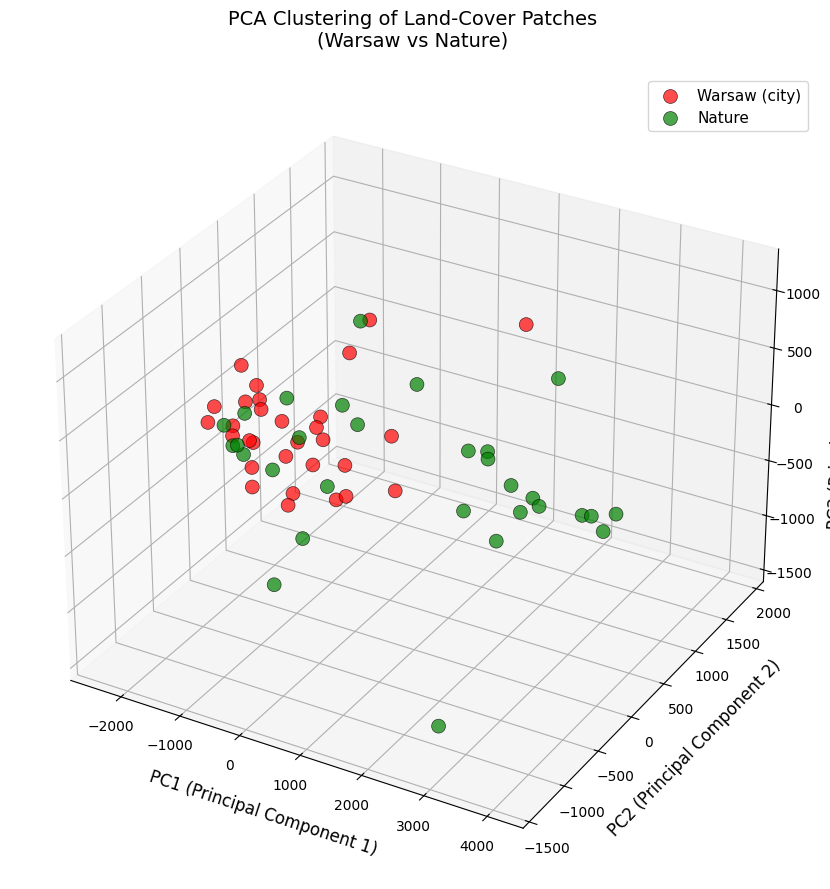

In [13]:
# 3D visualization of PCA results
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot each land-cover type with different colors
for lab, col, name in zip([0, 1], ['red', 'green'], ['Warsaw (city)', 'Nature']):
    indices = labels == lab
    ax.scatter(data_pca[indices, 0],
               data_pca[indices, 1],
               data_pca[indices, 2],
               c=col,
               label=name,
               alpha=0.7,
               s=100,
               edgecolors='black',
               linewidth=0.5)

ax.set_xlabel('PC1 (Principal Component 1)', fontsize=12, labelpad=10)
ax.set_ylabel('PC2 (Principal Component 2)', fontsize=12, labelpad=10)
ax.set_zlabel('PC3 (Principal Component 3)', fontsize=12, labelpad=10)
ax.legend(fontsize=11, loc='upper right')
ax.set_title('PCA Clustering of Land-Cover Patches\n(Warsaw vs Nature)', fontsize=14, pad=20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

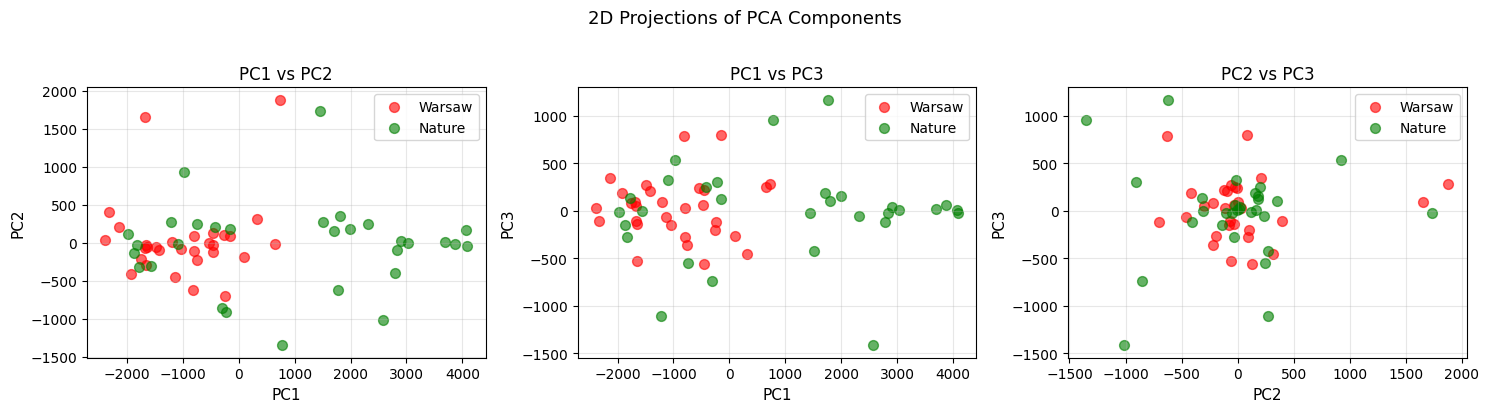

In [14]:
# Additional 2D projections
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

projections = [(0, 1, 'PC1', 'PC2'), (0, 2, 'PC1', 'PC3'), (1, 2, 'PC2', 'PC3')]

for ax, (pc1, pc2, label1, label2) in zip(axes, projections):
    for lab, col, name in zip([0, 1], ['red', 'green'], ['Warsaw', 'Nature']):
        indices = labels == lab
        ax.scatter(data_pca[indices, pc1],
                   data_pca[indices, pc2],
                   c=col,
                   label=name,
                   alpha=0.6,
                   s=50)
    ax.set_xlabel(label1, fontsize=11)
    ax.set_ylabel(label2, fontsize=11)
    ax.set_title(f'{label1} vs {label2}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('2D Projections of PCA Components', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### Observation

The plots show clustering of different land-cover types in PCA space. The clusters show
partial separation between Warsaw (urban) and Nature areas, with some overlap visible especially in PC1 vs PC2 and PC2 vs PC3 projections. This indicates that while there are distinct spectral characteristics between urban and nature areas, they share some common features. The PC1 vs PC3 projection shows the clearest separation between the two land-cover types.

## Task 2: Super-Resolution Autoencoder on EO Image

I will use an autoencoder to enhance the resolution of an EO image.

In [16]:
# Read EO image (using Warsaw image for super-resolution)
print("Reading EO image...")
img = np.array(Image.open('Warsaw_Poland.jpg').convert('L')).astype(np.float32)
img = (img - img.min()) / (img.max() - img.min())

print(f"Original image shape: {img.shape}")

Reading EO image...
Original image shape: (1575, 2362)


In [17]:
# Prepare data: low and high resolution
print("Preparing low-resolution and high-resolution data...")
lowres = resize(img, (img.shape[0]//2, img.shape[1]//2), anti_aliasing=True)
print(f"Low-resolution image shape: {lowres.shape}")

upscaled = resize(lowres, img.shape, anti_aliasing=True)
print(f"Upscaled image shape: {upscaled.shape}")

Preparing low-resolution and high-resolution data...
Low-resolution image shape: (787, 1181)
Upscaled image shape: (1575, 2362)


In [18]:
# Prepare data: patches from images
print("Preparing patches for training...")

def create_patches(low_res, high_res, patch_size=64, num_patches=100):
    """Extract random patches from images"""
    patches_lr = []
    patches_hr = []

    h, w = high_res.shape

    for _ in range(num_patches):
        # Random position
        y = np.random.randint(0, h - patch_size)
        x = np.random.randint(0, w - patch_size)

        # Extract patches
        patch_lr = low_res[y:y+patch_size, x:x+patch_size]
        patch_hr = high_res[y:y+patch_size, x:x+patch_size]

        patches_lr.append(patch_lr)
        patches_hr.append(patch_hr)

    return np.array(patches_lr), np.array(patches_hr)

# Create patches
X_train, y_train = create_patches(upscaled, img, patch_size=64, num_patches=200)

# Add channel dimension
X_train = X_train[..., np.newaxis]
y_train = y_train[..., np.newaxis]

print(f"Training input shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")

Preparing patches for training...
Training input shape: (200, 64, 64, 1)
Training target shape: (200, 64, 64, 1)


In [19]:
# Build autoencoder model
print("Building autoencoder model...")
input_img = layers.Input(shape=(64, 64, 1))  # stały rozmiar patcha

# Encoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Decoder
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Model summary:")
autoencoder.summary()

Building autoencoder model...
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,569 (256.13 KB)

 Trainable params: 65,569 (256.13 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
print("Training autoencoder")
history = autoencoder.fit(
    X_train, y_train,
    epochs=10,
    batch_size=8,
    verbose=2
)

Training autoencoder
Epoch 1/10
25/25 - 19s - 776ms/step - loss: 0.0132 - mae: 0.0872
Epoch 2/10
25/25 - 12s - 492ms/step - loss: 0.0066 - mae: 0.0577
Epoch 3/10
25/25 - 22s - 871ms/step - loss: 0.0050 - mae: 0.0496
Epoch 4/10
25/25 - 20s - 797ms/step - loss: 0.0052 - mae: 0.0512
Epoch 5/10
25/25 - 11s - 442ms/step - loss: 0.0043 - mae: 0.0456
Epoch 6/10
25/25 - 21s - 840ms/step - loss: 0.0039 - mae: 0.0426
Epoch 7/10
25/25 - 22s - 870ms/step - loss: 0.0037 - mae: 0.0414
Epoch 8/10
25/25 - 19s - 773ms/step - loss: 0.0035 - mae: 0.0404
Epoch 9/10
25/25 - 12s - 467ms/step - loss: 0.0035 - mae: 0.0399
Epoch 10/10
25/25 - 20s - 814ms/step - loss: 0.0034 - mae: 0.0389


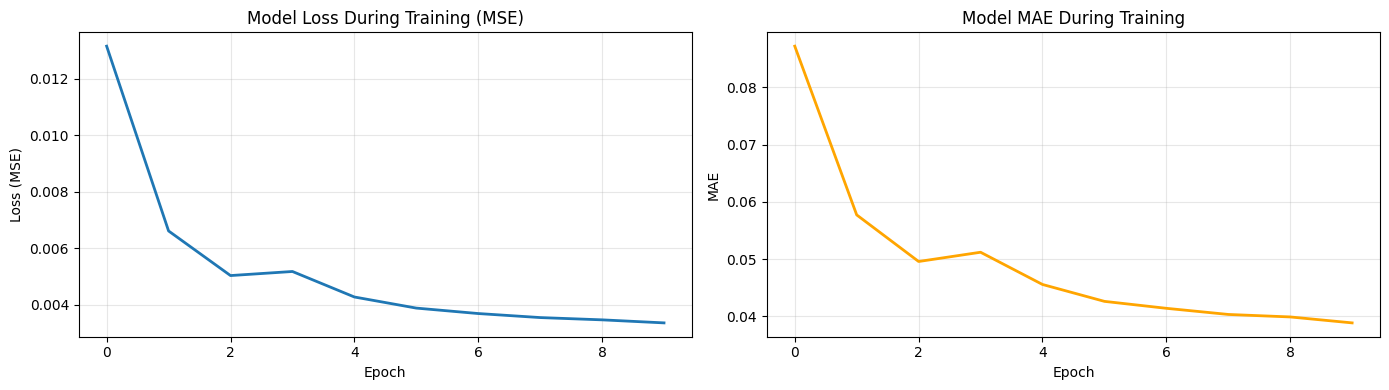

In [22]:
# Plot training loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(history.history['loss'], linewidth=2)
ax1.set_title('Model Loss During Training (MSE)', fontsize=12)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['mae'], linewidth=2, color='orange')
ax2.set_title('Model MAE During Training', fontsize=12)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Prediction
print("Generating super-resolution output")
output = autoencoder.predict(X_train)[0, ..., 0]

Generating super-resolution output
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step


/tmp/ipython-input-3161704994.py:26: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[1, 1].imshow(output[start_h:start_h+zoom_h, start_w:start_w+zoom_w], cmap='gray')
/tmp/ipython-input-3161704994.py:26: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[1, 1].imshow(output[start_h:start_h+zoom_h, start_w:start_w+zoom_w], cmap='gray')


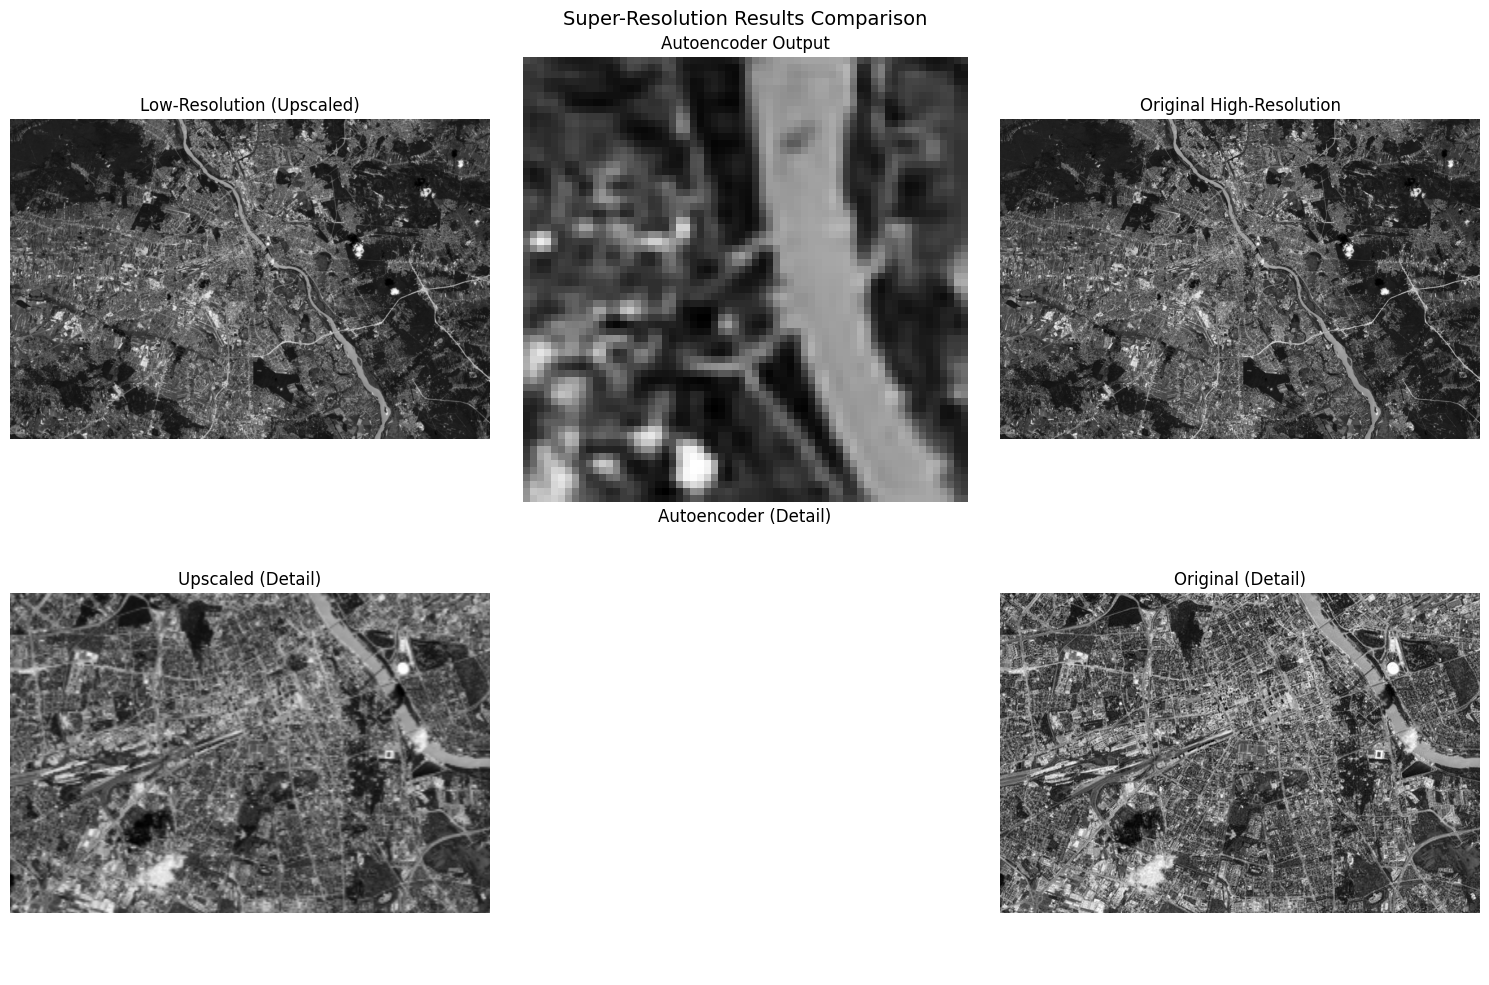

In [24]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# First row - full images
axes[0, 0].imshow(upscaled, cmap='gray')
axes[0, 0].set_title('Low-Resolution (Upscaled)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(output, cmap='gray')
axes[0, 1].set_title('Autoencoder Output', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(img, cmap='gray')
axes[0, 2].set_title('Original High-Resolution', fontsize=12)
axes[0, 2].axis('off')

# Second row - zoomed regions for detail comparison
h, w = img.shape
zoom_h, zoom_w = h//4, w//4
start_h, start_w = h//3, w//3

axes[1, 0].imshow(upscaled[start_h:start_h+zoom_h, start_w:start_w+zoom_w], cmap='gray')
axes[1, 0].set_title('Upscaled (Detail)', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(output[start_h:start_h+zoom_h, start_w:start_w+zoom_w], cmap='gray')
axes[1, 1].set_title('Autoencoder (Detail)', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(img[start_h:start_h+zoom_h, start_w:start_w+zoom_w], cmap='gray')
axes[1, 2].set_title('Original (Detail)', fontsize=12)
axes[1, 2].axis('off')

plt.suptitle('Super-Resolution Results Comparison', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [26]:
# Save output
print("Saving output image...")
output_img = Image.fromarray((output * 255).astype(np.uint8))
output_img.save('upscaled_output.png')
print("Output saved as 'upscaled_output.png'")

Saving output image...
Output saved as 'upscaled_output.png'


### Question 2: How can it be improved?

**Immediate improvements:**
1. **More training data**: Extracting more patches (1000+) from multiple diverse images would increase data diversity
2. **Longer training**: Training for 50-100 epochs until loss plateaus would allow better convergence
3. **Better architecture**:
   - Adding skip connections (U-Net style) between encoder and decoder would preserve spatial information
   - Increasing network depth to 6-8 layers would improve feature extraction capacity
   - Incorporating residual blocks would facilitate gradient flow
4. **Better loss function**: Combining MSE with perceptual loss or SSIM would better capture visual quality
5. **Larger patches**: Using 128×128 or 256×256 patches would capture more spatial context

**Advanced improvements:**
6. **Data augmentation**: Applying rotations, flips, and brightness/contrast adjustments would increase training variability
7. **Progressive training**: Starting with small patches and gradually increasing size would improve learning stability
8. **Attention mechanisms**: Adding attention layers would help the model focus on important features
9. **Ensemble approach**: Combining predictions from multiple models would reduce prediction variance
10. **Post-processing**: Applying edge enhancement or unsharp masking filters would improve perceived sharpness
